# Training NN (with custom implementation of CNN and SGD) on MNIST dataset  

In [1]:
import math
import time
import json
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime
from typing import List, Callable, Union, Tuple

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import torchvision
import torchvision.transforms as t
from plotly.subplots import make_subplots
from torch import Tensor
from torch.utils.data import DataLoader

import minigrad.nn as nn
from minigrad.core import Value, flatten, ValueMatrix, as_value_array, tanh, value_array_to_list
from minigrad.optimizer import SGD

## Data loading

In [2]:
def show_data(img, target, predictions=None):
    if predictions is not None:
        predictions = np.asarray(predictions)
        n = predictions.argmax()
        score = predictions[n]
        title = f'Ground Truth: {target}, Prediction: {n:d}, Score: {score:.3f}'
    else:
        title = f'Ground Truth: {target}'

    return px.imshow(img.squeeze(), color_continuous_scale='gray', title=title)

In [3]:
transforms = t.Compose([
    t.ToTensor(),
    # These values represent global mean and std of MNIST dataset.
    t.Normalize((0.1307,), (0.3081,)),
    t.Resize((15, 15)),
])

# List of tuples (img, label).
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms)

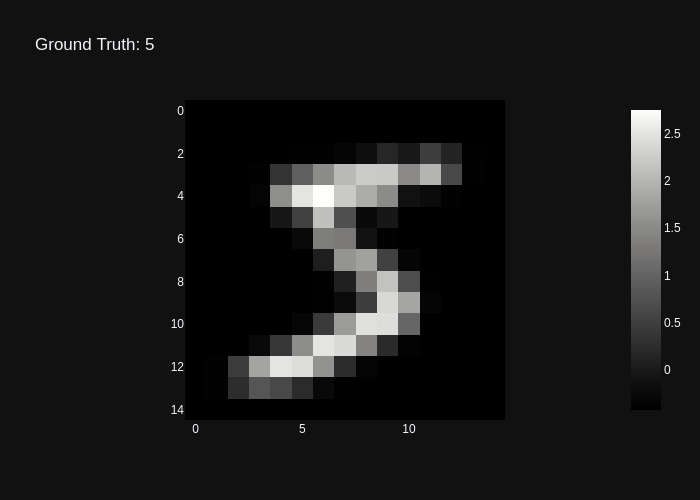

In [4]:
show_data(*train_dataset[0])

In [5]:
train_dataset[0][0].shape

torch.Size([1, 15, 15])

## Model definition

In [6]:
@dataclass
class CNNLayerConfig:
    out_channels: int
    kernel_size: int
    stride: int
    activation: Union[Callable[[Value], Value], None]


class CNN(nn.Module):
    """
    Architectures consists of various convolutional layers and MLP head with one hidden layer.
    """

    def __init__(
        self,
        width: int,
        height: int,
        in_channels: int,
        layers: List[CNNLayerConfig],
        hidden_dim: int = 30,
        n_classes: int = 10,
    ):
        self.width = width
        self.height = height
        self.in_channels = in_channels
        self.n_classes = n_classes

        curr_width = width
        curr_height = height
        curr_in_channels = in_channels
        self.conv_layers = []
        for i, l in enumerate(layers):
            if l.stride <= 0:
                raise ValueError(f'Invalid stride for conv layer {i} = {l}')

            if curr_height < l.kernel_size or curr_width < l.kernel_size:
                raise ValueError(
                    f'Invalid kernel size for conv layer {i}: {l}. Must be less than min({curr_height}, {curr_width})'
                )

            if (curr_height - l.kernel_size) % l.stride != 0 or (curr_width - l.kernel_size) % l.stride != 0:
                raise ValueError(
                    f'Combination of kernel and stride must precisely fit the image. No padding is supported. '
                    f'curr_width {curr_width}, curr_height {curr_height}, layer {i} = {l}'
                )

            conv = nn.Conv2D(
                width=curr_width,
                height=curr_height,
                kernel_size=l.kernel_size,
                stride=l.stride,
                in_channels=curr_in_channels,
                out_channels=l.out_channels,
                activation=l.activation,
            )
            curr_width = conv.out_width
            curr_height = conv.out_height
            curr_in_channels = conv.out_channels

            self.conv_layers.append(conv)

        last_conv = self.conv_layers[-1]
        self.linear = nn.Linear(last_conv.output_size, hidden_dim, tanh)
        self.out_proj = nn.Linear(hidden_dim, n_classes, tanh)

    def get_parameters(self) -> List[Value]:
        return flatten([
            [c.get_parameters() for c in self.conv_layers],
            self.linear.get_parameters(),
            self.out_proj.get_parameters(),
        ])
    
    def save(self, path: str):
        parameters = [v.v for v in self.get_parameters()]
        with open(path, 'w') as f:
            json.dump(parameters, f)
            
    def load(self, path: str):
        """
        :param path: path to the json file which contains an array of the float parameters.
        """
        with open(path, 'r') as f:
            new_parameters = json.load(f)
            for p, new_p in zip(self.get_parameters(), new_parameters):
                p.v = new_p
                p.grad = 0
                p.grad_fn = None
    
    def forward(self, x: List[ValueMatrix]) -> List[Value]:
        if len(x) != self.in_channels:
            raise ValueError(f'Invalid number of channels {len(x)}. Expected {self.in_channels}')

        for conv in self.conv_layers:
            x = conv.forward(x)

        x = flatten(x)
        x = self.linear.forward(x)
        out = self.out_proj.forward(x)

        assert len(out) == self.n_classes

        return out


In [7]:
model = CNN(
    width=15,
    height=15,
    in_channels=1,
    layers=[
        CNNLayerConfig(
            out_channels=15,
            kernel_size=5,
            stride=2,
            activation=tanh,
        ),
        CNNLayerConfig(
            out_channels=12,
            kernel_size=4,
            stride=2,
            activation=tanh,
        )
    ],
    hidden_dim=35,
    n_classes=10,
)

## Training

In [8]:
def mean_squared(y_arr: List[Value], y_pred_arr: List[Value]) -> Value:
    """
    For the simplicity we're using mean squared error, same as in LeCun 1989.    
    """
    loss = sum((y - y_pred).abs() ** 2 for y, y_pred in zip(y_arr, y_pred_arr)) / len(y_arr)
    return loss


def forward_training_batch(model: CNN, batch: List[Tuple[Tensor, Tensor]]) -> Value:
    """
    Computes the mean loss over a batch of samples by forwarding each sample, one by one, through the model.

    :param batch: List of input-target pairs.

    :return: The mean loss over the batch.
    """
    loss = Value(0)

    for (sample, target) in zip(batch[0], batch[1]):
        x = as_value_array(sample.numpy())
        y = as_value_array(-np.ones(model.n_classes, dtype=np.float64))
        y[target].v = 1

        y_pred = model.forward(x)

        loss += mean_squared(y, y_pred)

    loss = loss / len(batch)
    return loss


def evaluate(model: CNN, data_loader: DataLoader, sample_size: int, should_collect_preds: bool):
    stats = defaultdict(list)
    labeled_data = []

    # Currently only batch_size of 1 is supported during evaluation.    
    assert data_loader.batch_size == 1

    for i, (sample, target) in enumerate(data_loader):

        # Prepare input.
        sample = sample[0].numpy()
        x = as_value_array(sample)
        y = target.item()
        y_arr = as_value_array(-np.ones(model.n_classes, dtype=np.float64))
        y_arr[target].v = 1

        # Run prediction.        
        y_pred_arr = model.forward(x)
        loss = mean_squared(y_arr, y_pred_arr)

        y_pred_arr = value_array_to_list(y_pred_arr)
        y_pred = np.argmax(y_pred_arr)

        # Collect stats.
        stats['loss'].append(loss.v)
        stats['acc'].append(y_pred == y)

        if should_collect_preds:
            labeled_data.append({
                'img': sample,
                'y': y,
                'y_pred': y_pred,
                'y_arr': y_arr,
                'y_pred_arr': y_pred_arr,
            })

        if (i + 1) == sample_size:
            break

    stats = {k: np.mean(v) for k, v in stats.items()}
    print(f'=' * 50)
    print(f'Accuracy on the {sample_size} samples from evaluation dataset is {stats["acc"]}')
    print(f'=' * 50)

    if should_collect_preds:
        return stats, labeled_data
    else:
        return stats

### Training loop

In [9]:
epochs = 2
batch_size = 2

eval_freq = 500
eval_n_samples = 200

checkpoint_freq = 3000

optimizer = SGD(model.get_parameters(), lr=2e-3)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

train_stats = []
test_stats = []

In [ ]:
for epoch in range(epochs):

    epoch_start_time = time.time()

    for i, batch in enumerate(train_data_loader):
        batch_start_time = time.time()

        # Do one step of SGD.        
        optimizer.zero_grad()
        loss = forward_training_batch(model, batch)
        loss.backward()
        optimizer.step()

        print(f'Batch {i} done in {time.time() - batch_start_time}s. Current batch loss {loss.v}')
        train_stats.append({'loss': loss.v})

        # Evaluate on the sample of test dataset. Because of performance reasons, we're using small sample size.        
        if (i + 1) % eval_freq == 0:
            stats = evaluate(
                model,
                data_loader=test_data_loader,
                sample_size=eval_n_samples,
                should_collect_preds=False
            )
            test_stats.append(stats)

        # Create model checkpoint.
        if (i + 1) % checkpoint_freq == 0:
            model.save(f'model_epoch_{epoch}_batch_{i + 1}_{datetime.now().strftime("%m-%d_%H:%M")}.json')

    model.save(f'model_epoch_{epoch}.json')
    print(f'Epoch {epoch} done in {time.time() - epoch_start_time}s')

In [ ]:
# Save train and test stats.
train_stats = pd.DataFrame(train_stats)
test_stats = pd.DataFrame(test_stats)

train_stats.to_csv(f'train_stats.csv', index=False)
test_stats.to_csv(f'test_stats.csv', index=False)

### Visualization of the training progress

In [10]:
# Optional loading of saved statistics.
# train_stats = pd.read_csv('./artifacts/train_stats.csv')
# test_stats = pd.read_csv('./artifacts/test_stats.csv')

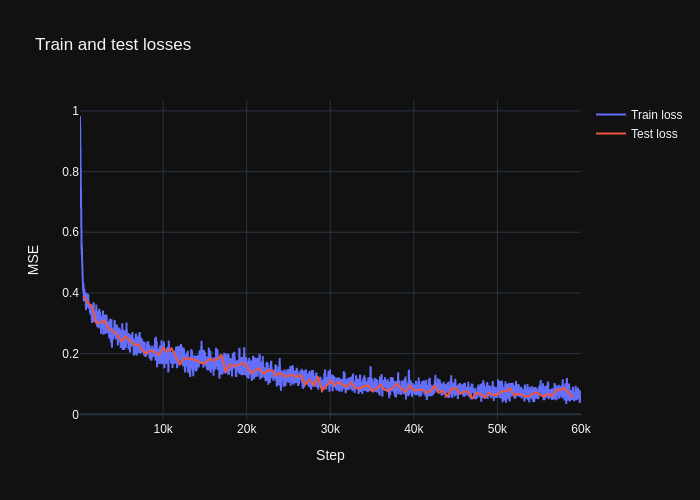

In [11]:
fig = go.Figure()

batch_window = 50
rolling_avg_batch_loss = train_stats['loss'].rolling(window=batch_window).mean().dropna()
fig.add_trace(
    go.Scatter(
        x=list(rolling_avg_batch_loss.index),
        y=rolling_avg_batch_loss,
        mode='lines',
        name=f'Train loss'
    )
)

fig.add_trace(
    go.Scatter(
        x=[i * eval_freq for i in range(1, len(test_stats) + 1)],
        y=test_stats['loss'],
        mode='lines',
        name=f'Test loss'
    )
)

fig.update_layout(
    title='Train and test losses',
    xaxis_title='Step',
    yaxis_title='MSE'
)
fig

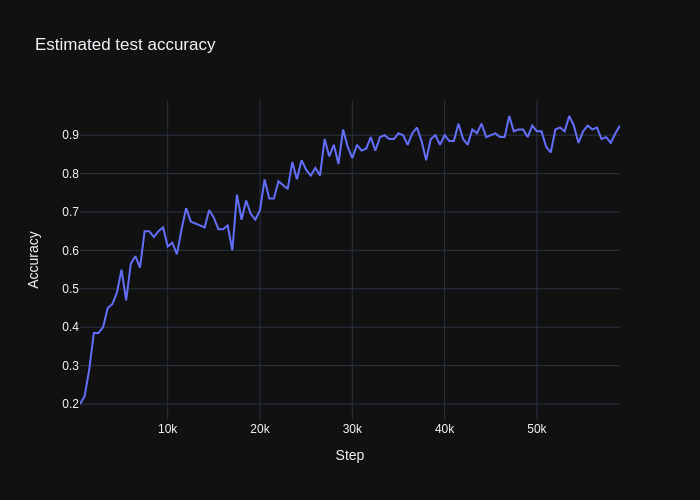

In [12]:
fig = px.line(
    test_stats,
    x=[i * eval_freq for i in range(1, len(test_stats) + 1)],
    y='acc',
    title=f'Estimated test accuracy'
)
fig.update_layout(xaxis_title='Step', yaxis_title='Accuracy')
fig

## Evaluation

In [15]:
# Optional loading of the saved model.
# model.load('./artifacts/model.json')

In [16]:
test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
stats, labeled_data = evaluate(model, test_data_loader, sample_size=len(test_dataset), should_collect_preds=True)

print(f'Test loss: {stats["loss"]}')
print(f'Test accuracy: {stats["acc"]}')

Accuracy on the 10000 samples from evaluation dataset is 0.9195
Test loss: 0.059446458760807494
Test accuracy: 0.9195


In [17]:
def show_prediction(img: np.ndarray, y: float, y_pred_arr: list, **kwargs):
    show_data(img, y, y_pred_arr).show()
    
    # Show scores for each class.
    x = np.arange(len(y_pred_arr))
    scores = px.bar(x=x, y=y_pred_arr, title='Scores for each class')
    scores.update_xaxes(tickmode='array', tickvals=x, title='Class')
    scores.update_yaxes(title='Score')
    scores.show()

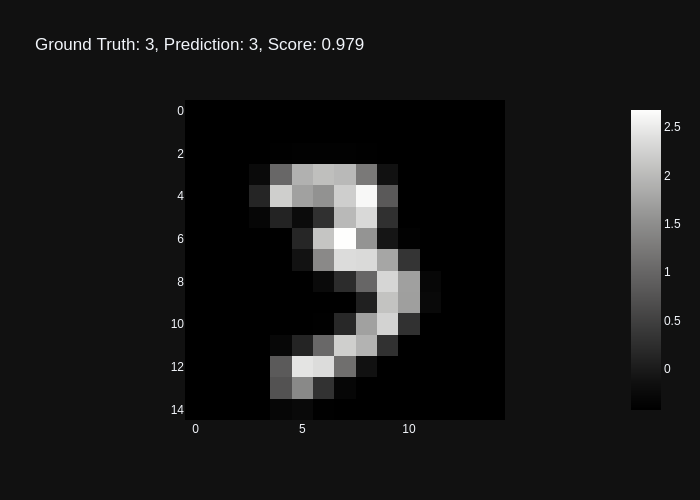

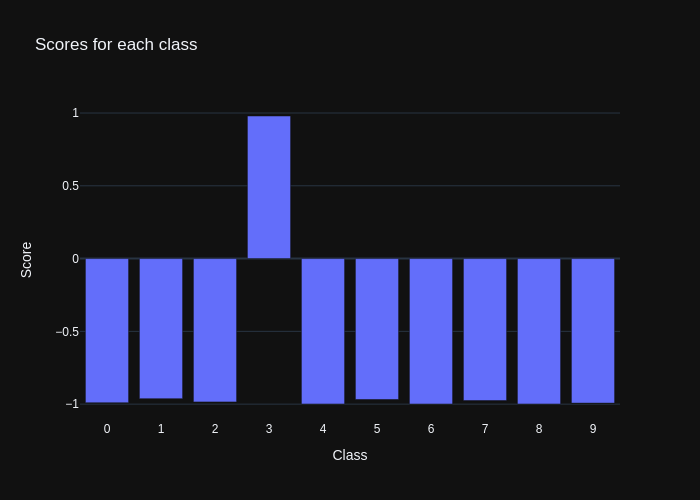

In [20]:
show_prediction(**labeled_data[30])

## Visualization of the learned filters

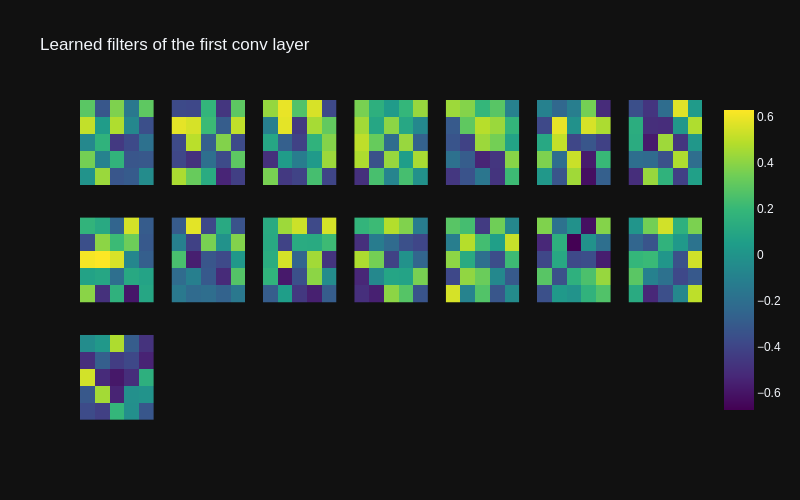

In [21]:
# noinspection PyShadowingBuiltins
def visualize_filters(filters: List[nn.Neuron], width: int, height: int, title: str = 'Learned filters'):
    """
    Supports visualization of the plain 2D filters (no channel dimension). 
    """
    cols = 7
    fig = make_subplots(rows=math.ceil(len(filters) / cols), cols=cols)
    for i, filter in enumerate(filters):
        filter = np.asarray([v.v for v in filter.weight])
        filter = filter.reshape((height, width))
        fig.add_trace(
            go.Heatmap(
                z=filter,
                colorscale='gray',
                showlegend=False,
                coloraxis='coloraxis'
            ),
            row=i // cols + 1,
            col=i % cols + 1,
        )
    fig.update_layout(title=title, showlegend=False, coloraxis={'colorscale': 'viridis'}, width=800)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


first_conv = model.conv_layers[0]
visualize_filters(
    first_conv.filters.neurons,
    first_conv.kernel_size,
    first_conv.kernel_size,
    title='Learned filters of the first conv layer'
)